In [16]:
import numpy as np
import umap

import logging
import matplotlib.pyplot as plt
from cycler import cycler
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

import pytorch_metric_learning
from pytorch_metric_learning import distances, losses, miners, reducers, testers, trainers, samplers
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [17]:
logging.getLogger().setLevel(logging.INFO)
logging.info("VERSION %s" % pytorch_metric_learning.__version__)

INFO:root:VERSION 2.4.1


In [3]:
%pdb

Automatic pdb calling has been turned ON


In [18]:
### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [19]:
# device = torch.device("cuda")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Taken from MNIST I guess? To check?

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

batch_size = 256
num_epochs = 1

In [8]:
train_dataset = datasets.MNIST(".", train=True, download=True, transform=transform)
val_dataset = datasets.MNIST(".", train=False, transform=transform)

In [9]:
record_keeper, _, _ = logging_presets.get_record_keeper(
    "example_logs", "example_tensorboard"
)

hooks = logging_presets.get_hook_container(record_keeper)

def visualizer_hook(umapper, umap_embeddings, labels, split_name, keyname, *args):
    logging.info(
        "UMAP plot for the {} split and label set {}".format(split_name, keyname)
    )
    label_set = np.unique(labels)
    num_classes = len(label_set)
    plt.figure(figsize=(20, 15))
    plt.gca().set_prop_cycle(
        cycler(
            "color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]
        )
    )
    for i in range(num_classes):
        idx = labels == label_set[i]
        plt.plot(umap_embeddings[idx, 0], umap_embeddings[idx, 1], ".", markersize=1)
    plt.show()

In [10]:
tester = testers.GlobalEmbeddingSpaceTester(
    end_of_testing_hook=hooks.end_of_testing_hook,
    visualizer=umap.UMAP(),
    visualizer_hook=visualizer_hook,
    dataloader_num_workers=2,
    accuracy_calculator=AccuracyCalculator(k="max_bin_count"),
)

dataset_dict = {"val": val_dataset}
model_folder = "example_saved_models"

end_of_epoch_hook = hooks.end_of_epoch_hook(
    tester, dataset_dict, model_folder, test_interval=1, patience=1
)

In [12]:
# Set the loss function
loss = losses.TripletMarginLoss(margin=0.2)

distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)

# Set the mining function
miner = miners.TripletMarginMiner(
    margin=0.2, 
    distance=distance, 
    type_of_triplets="semihard",
)

# Set the dataloader sampler
sampler = samplers.MPerClassSampler(
    train_dataset.targets, 
    m=4, 
    length_before_new_iter=len(train_dataset),
)

# FIXME
sampler = None

# Package the above stuff into dictionaries.
trunk = Net().to(device)
models = {"trunk": trunk}
# models = {"trunk": trunk, "embedder": embedder, "classifier": classifier}

trunk_optimizer = torch.optim.Adam(trunk.parameters(), lr=0.01)

optimizers = {
    "trunk_optimizer": trunk_optimizer,
    # "embedder_optimizer": embedder_optimizer,
    # "classifier_optimizer": classifier_optimizer,
}

loss_funcs = {
    "metric_loss": loss_func, 
    # "classifier_loss": classification_loss,
}
mining_funcs = {"tuple_miner": miner}
mining_funcs = None

# We can specify loss weights if we want to. This is optional
loss_weights = {
    "metric_loss": 1, 
    # "classifier_loss": 0.5,
}

trainer = trainers.MetricLossOnly(
    models,
    optimizers,
    batch_size,
    loss_funcs,
    train_dataset,
    mining_funcs=mining_funcs,
    sampler=sampler,
    dataloader_num_workers=2,
    loss_weights=loss_weights,
    end_of_iteration_hook=hooks.end_of_iteration_hook,
    end_of_epoch_hook=end_of_epoch_hook,
)

INFO:PML:Evaluating epoch 1
INFO:PML:Getting embeddings for the val split
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.65it/s]
INFO:PML:Running UMAP on the val set
/home/chouffe/miniconda3/envs/fruitpunch_bears/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


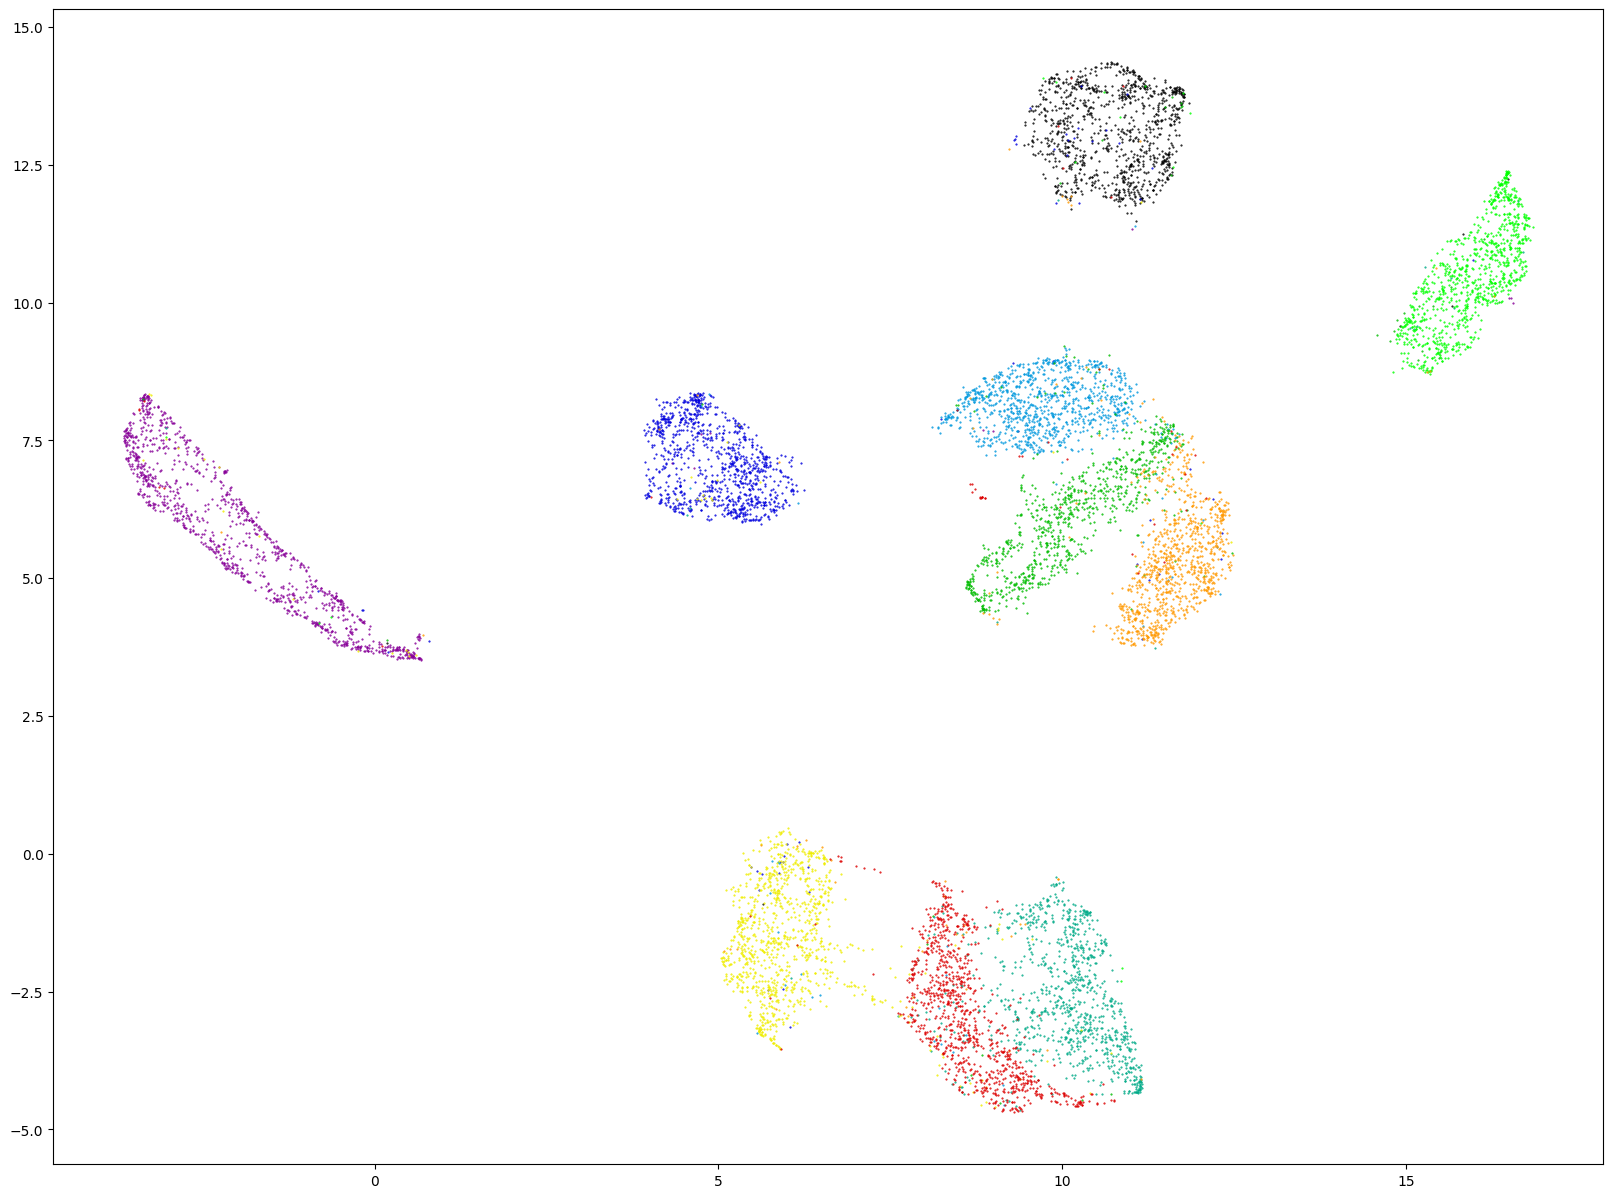

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=1135
INFO:PML:embedding dimensionality is 128
/home/chouffe/miniconda3/envs/fruitpunch_bears/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)
INFO:PML:running k-means clustering with k=10
INFO:PML:embedding dimensionality is 128


defaultdict(dict,
            {'val': {'epoch': 1,
              'AMI_level0': 0.46856098679848823,
              'NMI_level0': 0.4695062146010084,
              'mean_average_precision_level0': 0.3304068385013054,
              'mean_average_precision_at_r_level0': 0.3190593764176617,
              'mean_reciprocal_rank_level0': 0.970155656337738,
              'precision_at_1_level0': 0.9554,
              'r_precision_level0': 0.430762113751966}})

In [13]:
tester.test(dataset_dict, 1, trunk)

INFO:PML:Initializing dataloader
INFO:PML:Initializing dataloader iterator
INFO:PML:Done creating dataloader iterator
INFO:PML:TRAINING EPOCH 1
total_loss=0.19782: 100%|████████████████████████████████████████████████████████████████████████████████████████| 468/468 [01:12<00:00,  6.49it/s]
INFO:PML:Evaluating epoch 1
INFO:PML:Getting embeddings for the val split
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:07<00:00, 43.89it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


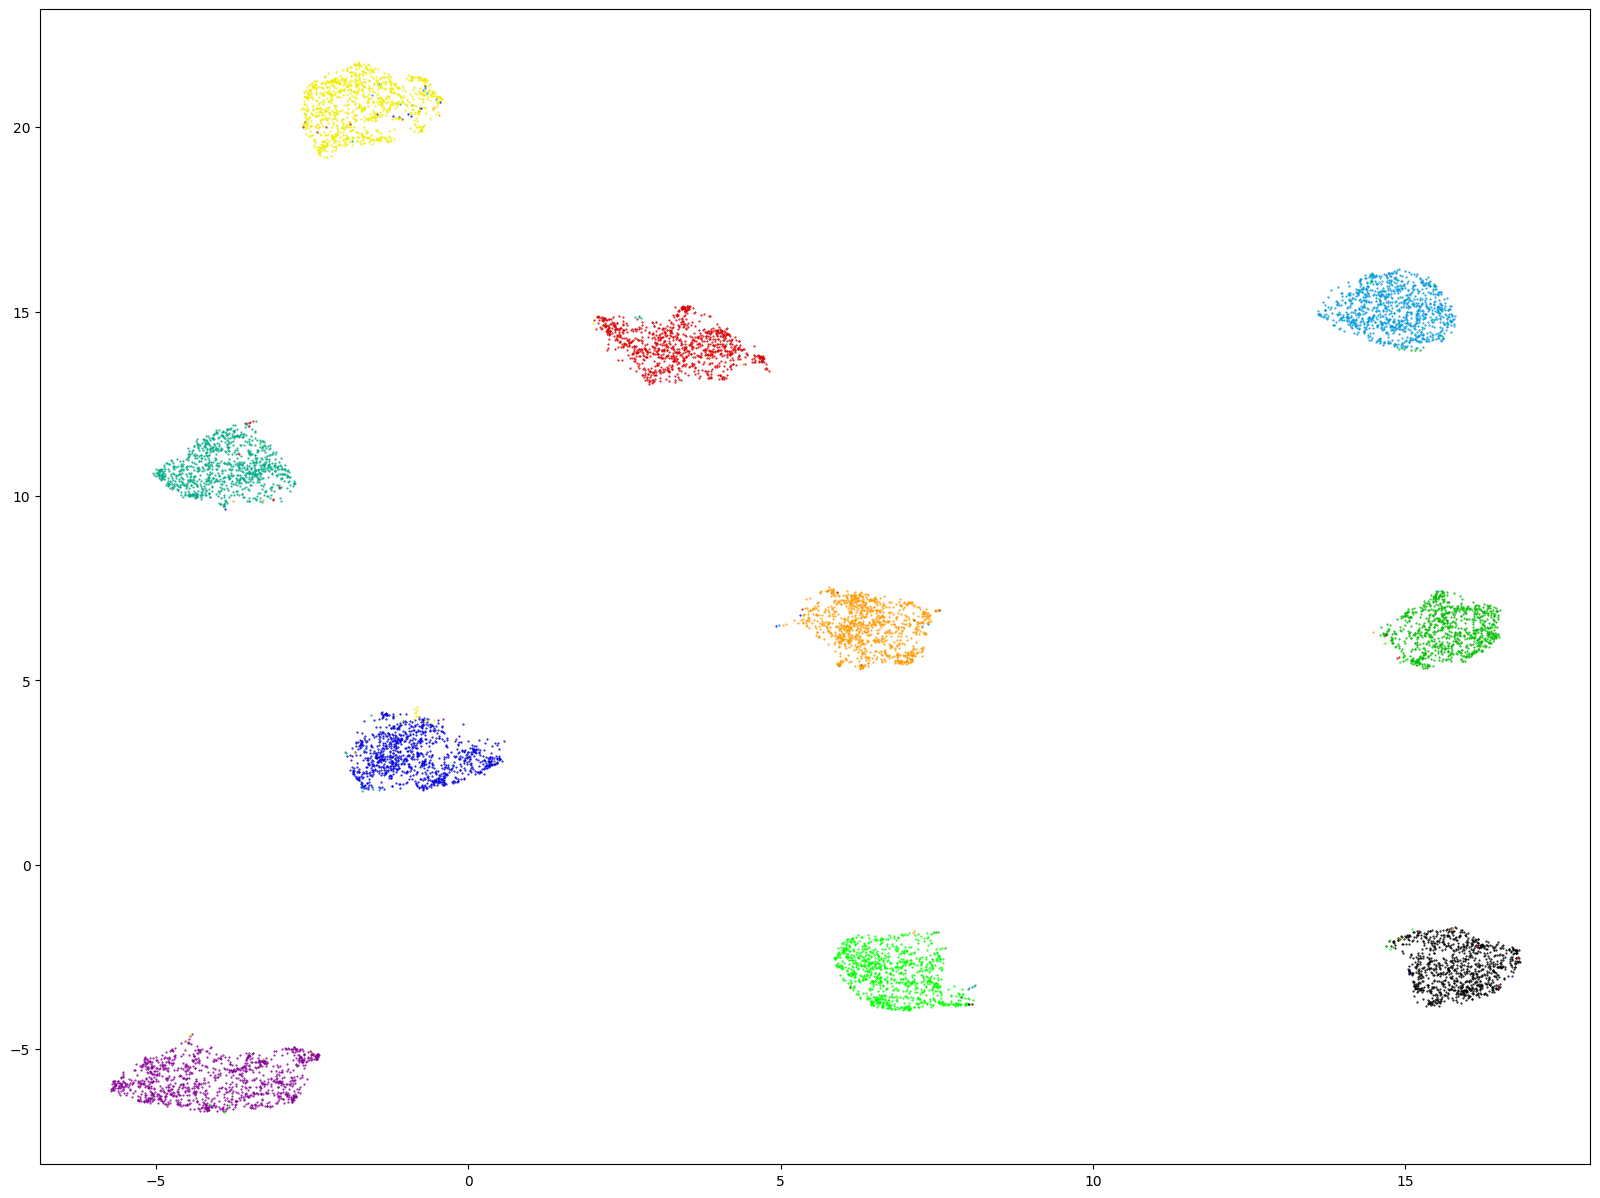

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=1135
INFO:PML:embedding dimensionality is 128
INFO:PML:running k-means clustering with k=10
INFO:PML:embedding dimensionality is 128


In [14]:
trainer.train(num_epochs=1)

INFO:PML:Evaluating epoch 1
INFO:PML:Getting embeddings for the val split
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:07<00:00, 40.23it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


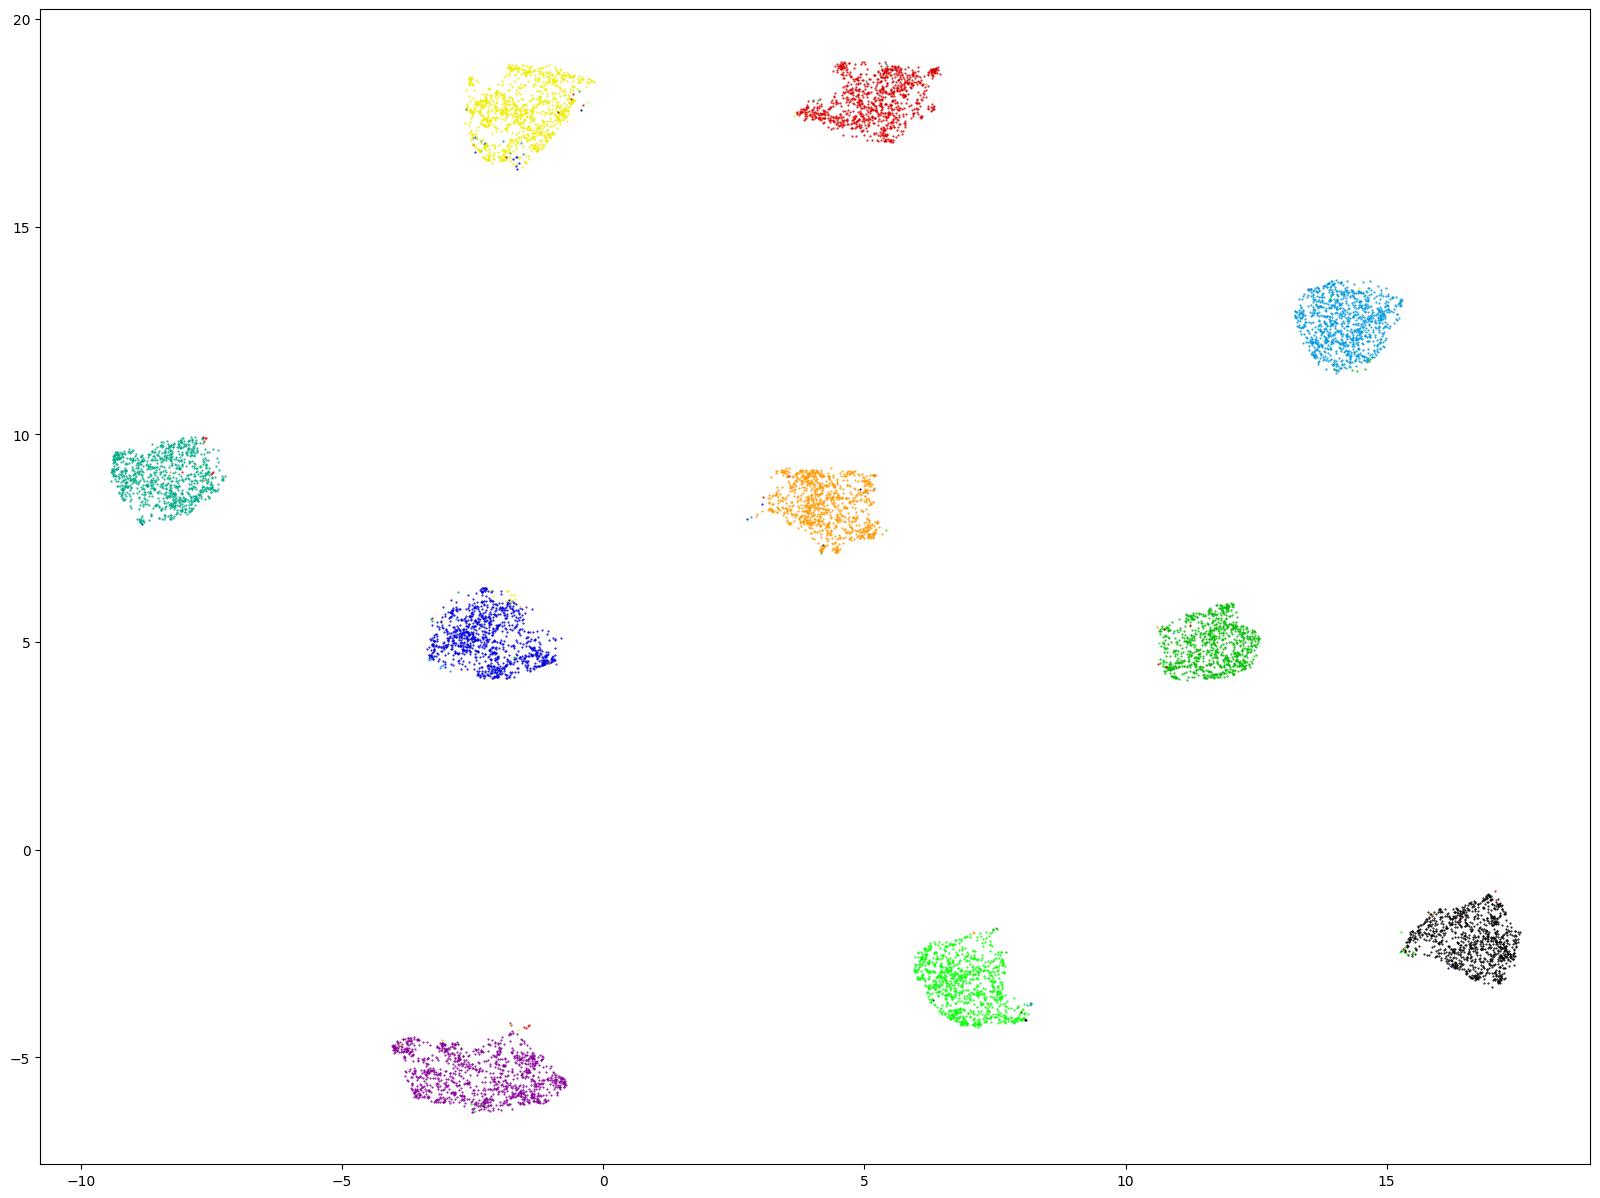

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=1135
INFO:PML:embedding dimensionality is 128
INFO:PML:running k-means clustering with k=10
INFO:PML:embedding dimensionality is 128


defaultdict(dict,
            {'val': {'epoch': 1,
              'AMI_level0': 0.8538871982795176,
              'NMI_level0': 0.8541533361729522,
              'mean_average_precision_level0': 0.9522398318899593,
              'mean_average_precision_at_r_level0': 0.9341243969754153,
              'mean_reciprocal_rank_level0': 0.9889261722564697,
              'precision_at_1_level0': 0.9842,
              'r_precision_level0': 0.9446217903303253}})

In [15]:
tester.test(dataset_dict, 1, trunk)